In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as pt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, log_loss, balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from imblearn.over_sampling import SMOTE
%matplotlib inline

In [2]:
#Import dataset
# prompt:  mounted your Google Drive in Colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# prompt: 阅读Google 云盘My Drive/Colab Notebook/M4 Hackathon 中的train 和 test 两个csv，储存为 train 和 test

# Assuming you have mounted your Google Drive in Colab
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/M4 Hackathon/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/M4 Hackathon/test.csv')


In [ ]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,Male,50.0,0,0,Yes,Private,Rural,88.10,29.1,formerly smoked,0
1,2,Female,52.0,0,0,Yes,Private,Rural,80.07,38.9,smokes,0
2,3,Female,26.0,0,0,No,Govt_job,Urban,89.11,23.3,smokes,0
3,4,Female,37.0,0,0,Yes,Private,Rural,81.36,36.1,never smoked,0
4,5,Male,59.0,0,0,Yes,Private,Rural,82.59,29.6,never smoked,1


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12243 non-null  int64  
 1   gender             12243 non-null  object 
 2   age                12243 non-null  float64
 3   hypertension       12243 non-null  int64  
 4   heart_disease      12243 non-null  int64  
 5   ever_married       12243 non-null  object 
 6   work_type          12243 non-null  object 
 7   Residence_type     12243 non-null  object 
 8   avg_glucose_level  12243 non-null  float64
 9   bmi                12243 non-null  float64
 10  smoking_status     12243 non-null  object 
 11  stroke             12243 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


In [4]:
numerical_features = [
    "age", "avg_glucose_level", "bmi"
]
categorical_features = [
    "gender", "hypertension","heart_disease",
    "ever_married", "work_type","Residence_type",
    "smoking_status"
]

In [ ]:
train.isnull().sum()

,0
id,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0


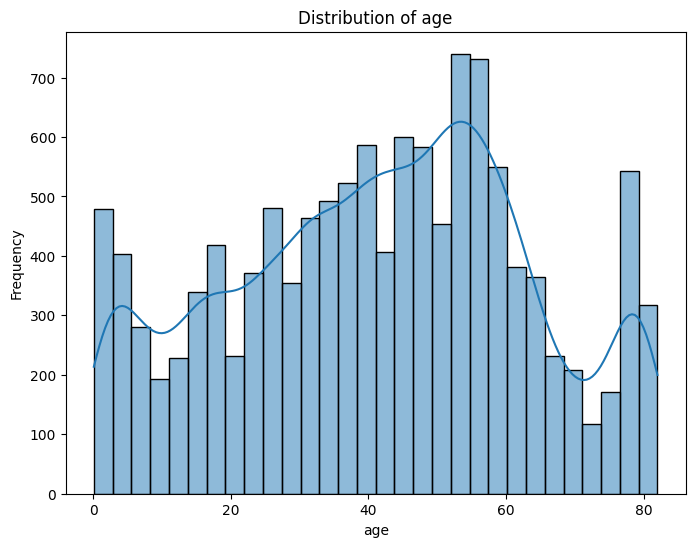

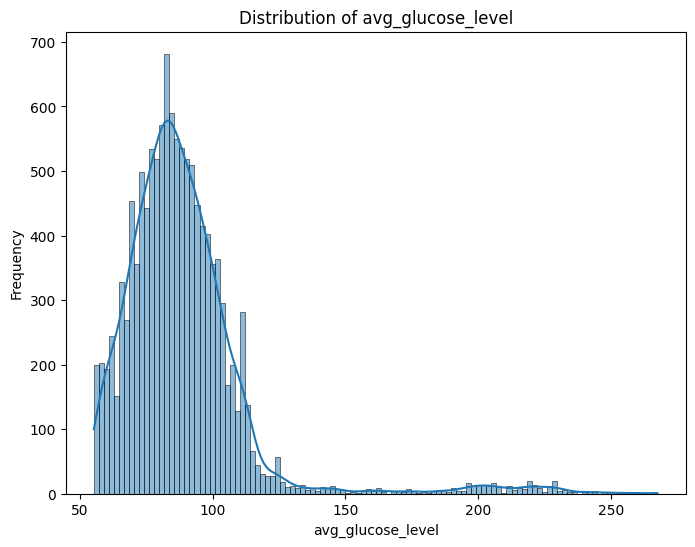

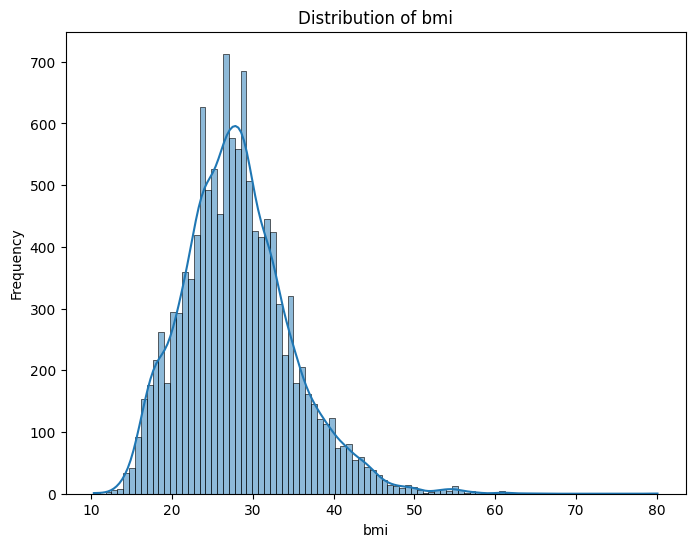

In [ ]:
# prompt: 生成numerical_features 的数据分布图

# Assuming 'numerical_features' is defined as in your previous code.

for col in numerical_features:
  plt.figure(figsize=(8, 6))
  sns.histplot(train[col], kde=True)
  plt.title(f'Distribution of {col}')
  plt.xlabel(col)
  plt.ylabel('Frequency')
  plt.show()


In [5]:
def remove_outliers_tukey(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Plot before removing outliers
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=cleaned_df[col])
        plt.title(f"Before Removing Outliers: {col}")
        plt.show()

        # Remove outliers
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

        # Plot after removing outliers
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=cleaned_df[col])
        plt.title(f"After Removing Outliers: {col}")
        plt.show()

    return cleaned_df

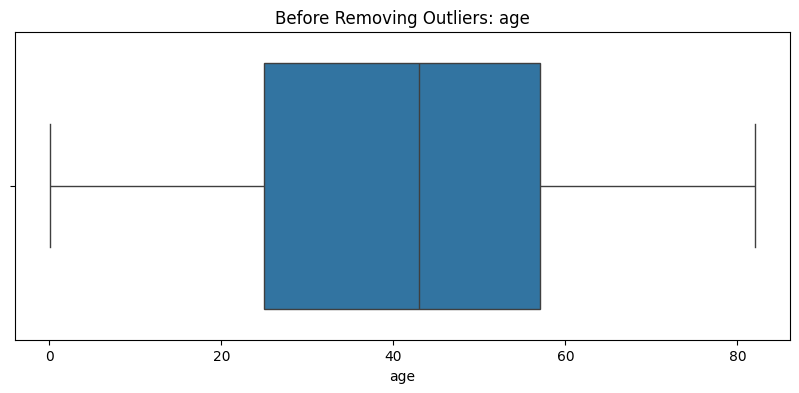

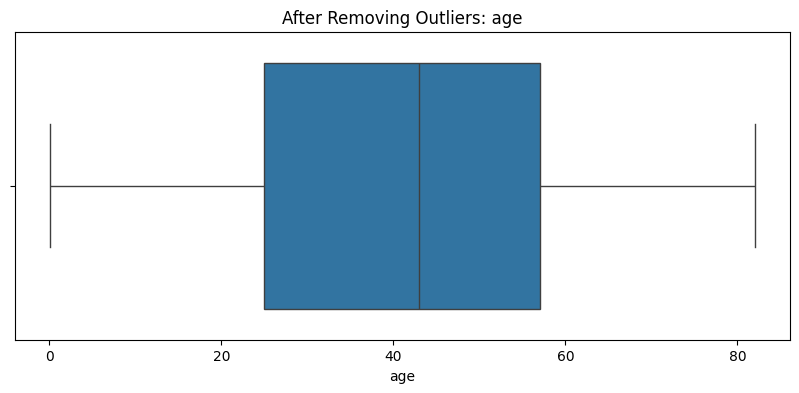

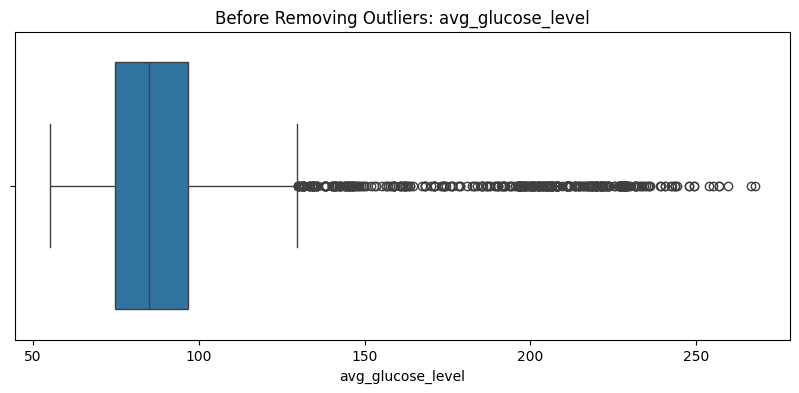

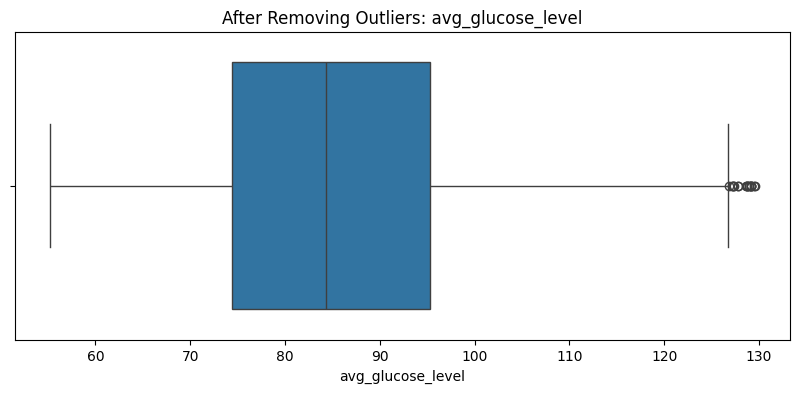

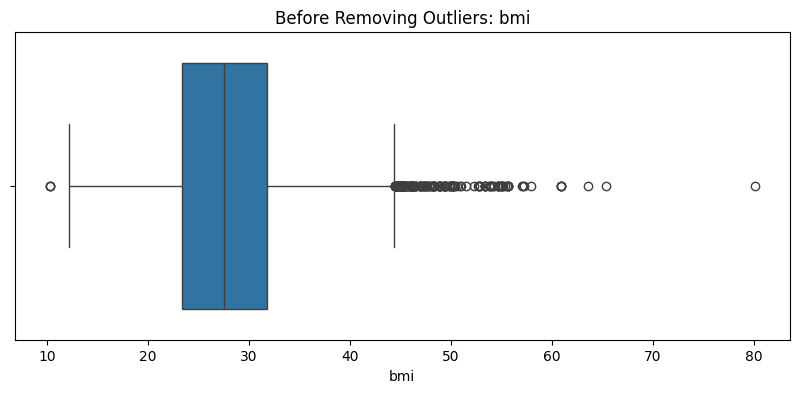

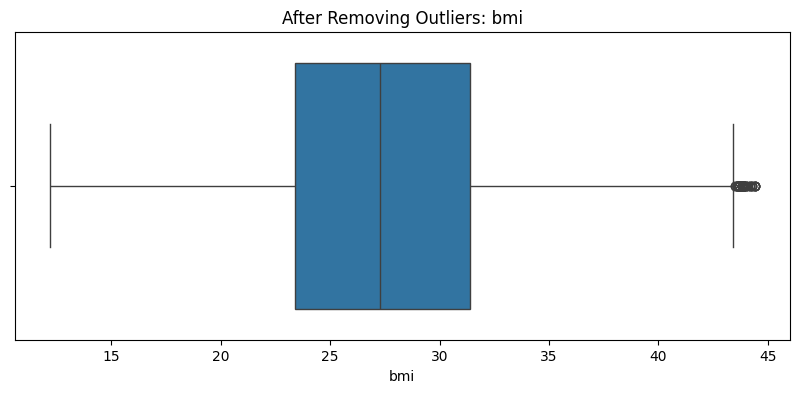

In [6]:
# prompt: 移除train 中 avg_glucose_level>150 的行
#Data processing
#train = train[train['avg_glucose_level'] <= 150]
#train = train[train['bmi'] <= 50]
train = train.drop('id', axis=1)
train = train[train['gender'] != 'Other']
train_cleaned = remove_outliers_tukey(train, numerical_features)

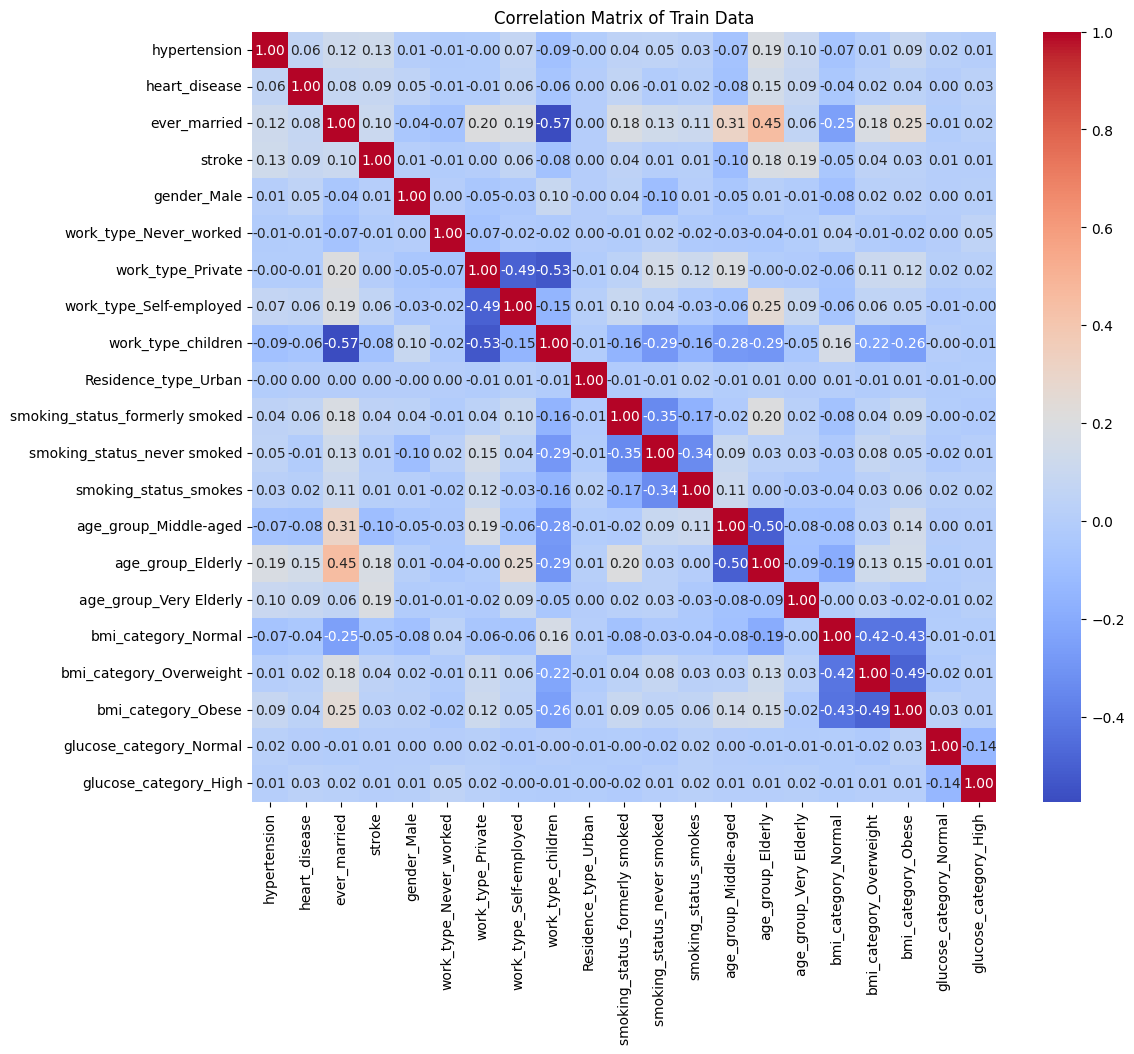

In [ ]:
corr_matrix = train.select_dtypes(include=np.number).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Train Data')
plt.show()

In [ ]:
#cat_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
#train = pd.get_dummies(train, columns=cat_features, drop_first=True)
#test = pd.get_dummies(test, columns=cat_features, drop_first=True)

In [7]:
cat_features = ['gender', 'work_type', 'Residence_type', 'smoking_status']
train = pd.get_dummies(train, columns=cat_features, drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=cat_features, drop_first=True, dtype=int)

In [8]:
train['age_group'] = pd.cut(train['age'], bins=[0, 25, 45, 60, 120], labels=["Young", "Middle-aged", "Elderly", "Very Elderly"])
test['age_group'] = pd.cut(test['age'], bins=[0, 25, 45, 60, 120], labels=["Young", "Middle-aged", "Elderly", "Very Elderly"])
train = pd.get_dummies(train, columns=['age_group'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['age_group'], drop_first=True, dtype=int)
train['bmi_category'] = pd.cut(train['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Normal", "Overweight", "Obese"])
test['bmi_category'] = pd.cut(test['bmi'], bins=[0, 18.5, 24.9, 29.9, 100], labels=["Underweight", "Normal", "Overweight", "Obese"])
train = pd.get_dummies(train, columns=['bmi_category'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['bmi_category'], drop_first=True, dtype=int)
train['glucose_category'] = pd.cut(train['avg_glucose_level'], bins=[0, 70, 140, 300], labels=["Low", "Normal", "High"])
test['glucose_category'] = pd.cut(test['avg_glucose_level'], bins=[0, 70, 140, 300], labels=["Low", "Normal", "High"])
train = pd.get_dummies(train, columns=['glucose_category'], drop_first=True, dtype=int)
test = pd.get_dummies(test, columns=['glucose_category'], drop_first=True, dtype=int)

In [9]:
train = train.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)
test = test.drop(['age', 'avg_glucose_level', 'bmi'], axis=1)

In [10]:
train['ever_married'] = train['ever_married'].map({'Yes': 1, 'No': 0})
test['ever_married'] = test['ever_married'].map({'Yes': 1, 'No': 0})

In [ ]:
train.head()

,hypertension,heart_disease,ever_married,stroke,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,...,smoking_status_never smoked,smoking_status_smokes,age_group_Middle-aged,age_group_Elderly,age_group_Very Elderly,bmi_category_Normal,bmi_category_Overweight,bmi_category_Obese,glucose_category_Normal,glucose_category_High
0,0,0,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,0,0,1,0,0,0,1,0,0,0,...,0,1,0,1,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,1,0
3,0,0,1,0,0,0,1,0,0,0,...,1,0,1,0,0,0,0,1,1,0
4,0,0,1,1,1,0,1,0,0,0,...,1,0,0,1,0,0,1,0,1,0


In [ ]:
train.isnull().sum()

,0
age,0
hypertension,0
heart_disease,0
ever_married,0
avg_glucose_level,0
bmi,0
stroke,0
gender_Male,0
gender_Other,0
work_type_Never_worked,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11852 entries, 0 to 12242
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   hypertension                    11852 non-null  int64
 1   heart_disease                   11852 non-null  int64
 2   ever_married                    11852 non-null  int64
 3   stroke                          11852 non-null  int64
 4   gender_Male                     11852 non-null  int64
 5   work_type_Never_worked          11852 non-null  int64
 6   work_type_Private               11852 non-null  int64
 7   work_type_Self-employed         11852 non-null  int64
 8   work_type_children              11852 non-null  int64
 9   Residence_type_Urban            11852 non-null  int64
 10  smoking_status_formerly smoked  11852 non-null  int64
 11  smoking_status_never smoked     11852 non-null  int64
 12  smoking_status_smokes           11852 non-null  int64
 13  age_gr

In [ ]:
"""""
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import pandas as pd

X = train.drop('stroke', axis=1)
y = train['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=222, stratify=y
)

# 查看拆分后训练集中的标签分布
print("Stroke Cases before SMOTE:")
print(y_train.value_counts(normalize=True))

# 在训练集上使用 SMOTE 进行过采样平衡标签数据
smote = SMOTE(random_state=222)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 查看经过 SMOTE 处理后训练集中的标签分布
print("Stroke Cases after SMOTE:")
print(pd.Series(y_train_sm).value_counts(normalize=True))

Stroke Cases before SMOTE:
stroke
0    0.964033
1    0.035967
Name: proportion, dtype: float64
Stroke Cases after SMOTE:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64


In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# 假设 train 是原始的 DataFrame，且 'stroke' 为目标变量
X = train.drop('stroke', axis=1)
y = train['stroke']

# 查看原始数据集中各类别的比例
print("Original Stroke Cases distribution:")
print(y.value_counts(normalize=True))

# 先对整个数据集应用 SMOTE 进行过采样平衡
smote = SMOTE(random_state=222)
X_sm, y_sm = smote.fit_resample(X, y)

print("\nStroke Cases distribution after SMOTE:")
print(pd.Series(y_sm).value_counts(normalize=True))

# 然后将平衡后的数据集按 8:2 的比例划分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=222, stratify=y_sm
)

# 查看划分后训练集中的标签分布
print("\nTraining set Stroke Cases distribution:")
print(pd.Series(y_train).value_counts(normalize=True))

Original Stroke Cases distribution:
stroke
0    0.958667
1    0.041333
Name: proportion, dtype: float64

Stroke Cases distribution after SMOTE:
stroke
0    0.5
1    0.5
Name: proportion, dtype: float64

Training set Stroke Cases distribution:
stroke
1    0.500027
0    0.499973
Name: proportion, dtype: float64


In [ ]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 18777 entries, 17158 to 6679
Series name: stroke
Non-Null Count  Dtype
--------------  -----
18777 non-null  int64
dtypes: int64(1)
memory usage: 293.4 KB



============ Logistic Regression ============
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.67      0.74      1828
           1       0.72      0.87      0.79      1828

    accuracy                           0.77      3656
   macro avg       0.78      0.77      0.77      3656
weighted avg       0.78      0.77      0.77      3656

Accuracy: 0.7694
F1 Score: 0.7905
ROC AUC: 0.8236791294188625
Confusion Matrix:
[[1223  605]
 [ 238 1590]]


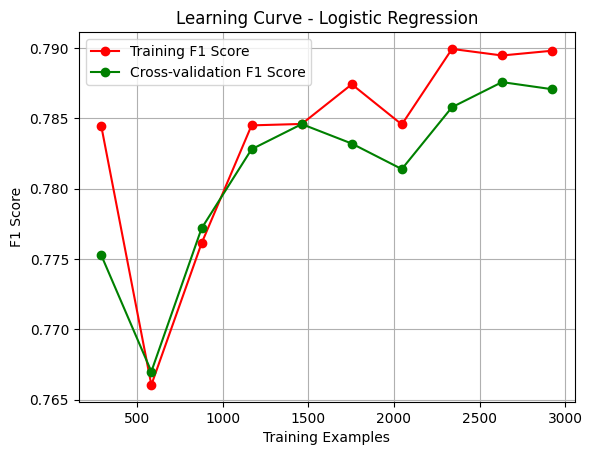


============ Decision Tree ============
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.82      0.87      1828
           1       0.84      0.94      0.89      1828

    accuracy                           0.88      3656
   macro avg       0.89      0.88      0.88      3656
weighted avg       0.89      0.88      0.88      3656

Accuracy: 0.8824
F1 Score: 0.8891
ROC AUC: 0.9542297904227457
Confusion Matrix:
[[1502  326]
 [ 104 1724]]


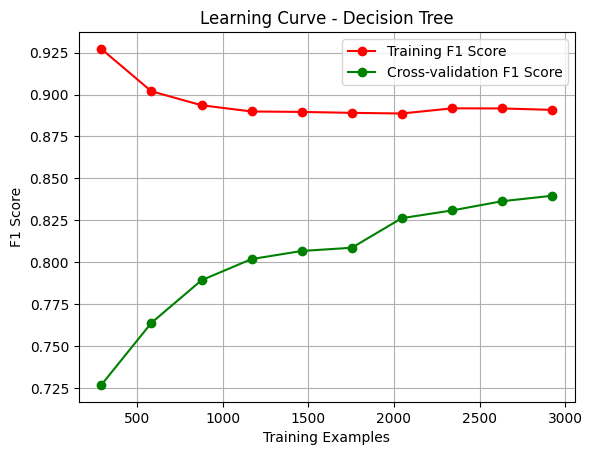


============ Random Forest ============
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.81      0.87      1828
           1       0.84      0.95      0.89      1828

    accuracy                           0.88      3656
   macro avg       0.89      0.88      0.88      3656
weighted avg       0.89      0.88      0.88      3656

Accuracy: 0.8824
F1 Score: 0.8901
ROC AUC: 0.9527080570172708
Confusion Matrix:
[[1484  344]
 [  86 1742]]


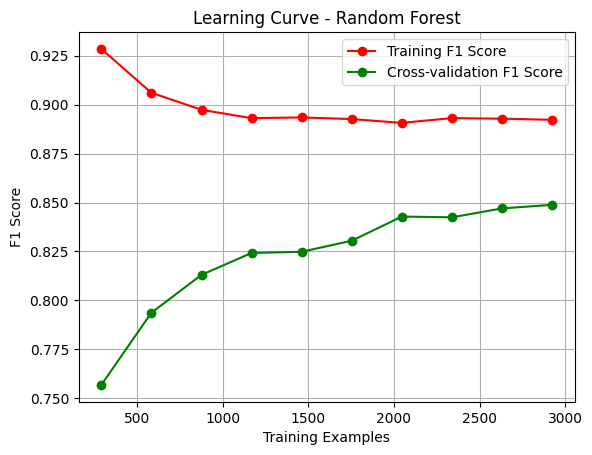


============ Gradient Boosting ============
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.69      0.79      1828
           1       0.75      0.93      0.83      1828

    accuracy                           0.81      3656
   macro avg       0.83      0.81      0.81      3656
weighted avg       0.83      0.81      0.81      3656

Accuracy: 0.8121
F1 Score: 0.8326
ROC AUC: 0.8746190429449028
Confusion Matrix:
[[1261  567]
 [ 120 1708]]


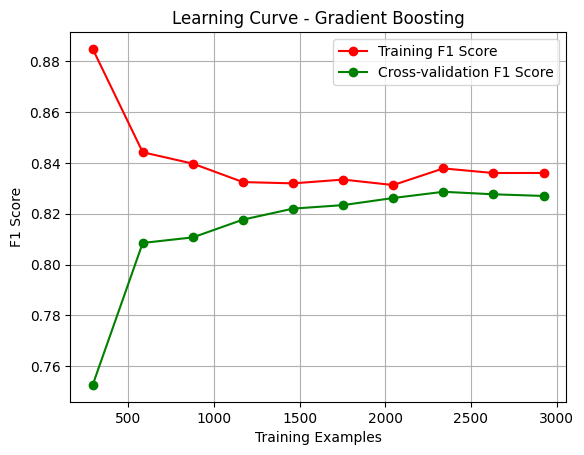


============ SVC ============
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.69      0.80      1828
           1       0.76      0.95      0.84      1828

    accuracy                           0.82      3656
   macro avg       0.84      0.82      0.82      3656
weighted avg       0.84      0.82      0.82      3656

Accuracy: 0.8219
F1 Score: 0.8420
ROC AUC: 0.8893626495697848
Confusion Matrix:
[[1270  558]
 [  93 1735]]


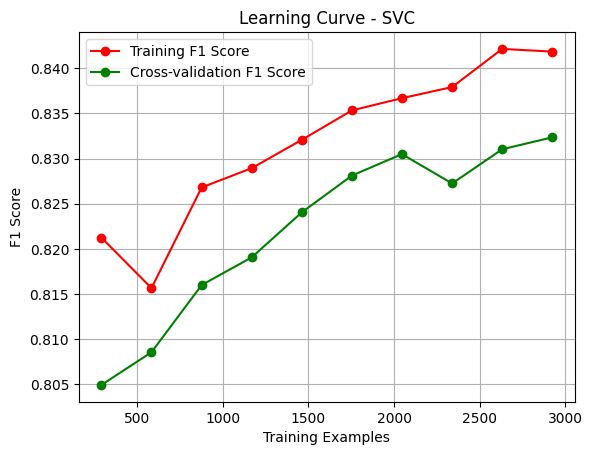

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC


# 随机抽取 20% 的数据样本，保持类别分布（stratify）
X_sample, _, y_sample, _ = train_test_split(
    X_train_sm, y_train_sm, train_size=0.2, random_state=222, stratify=y_train_sm
)

# 定义多个分类模型
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=222),
    "Decision Tree": DecisionTreeClassifier(random_state=222),
    "Random Forest": RandomForestClassifier(random_state=222),
    "Gradient Boosting": GradientBoostingClassifier(random_state=222),
    "SVC": SVC(probability=True, random_state=222)
}

# 遍历每个模型，进行训练、评估和绘制学习曲线
for name, model in models.items():
    print(f"\n============ {name} ============")

    # 在抽样数据上训练模型
    model.fit(X_sample, y_sample)

    # 模型预测（这里为了示例直接在训练样本上评估，实际应用中建议用交叉验证或独立测试集）
    y_pred = model.predict(X_sample)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_sample)[:, 1]
        roc_auc = roc_auc_score(y_sample, y_proba)
    else:
        roc_auc = "N/A"

    # 输出评估指标
    print("Classification Report:")
    print(classification_report(y_sample, y_pred))
    print("Accuracy: {:.4f}".format(accuracy_score(y_sample, y_pred)))
    print("F1 Score: {:.4f}".format(f1_score(y_sample, y_pred)))
    print("ROC AUC: {}".format(roc_auc))
    print("Confusion Matrix:")
    print(confusion_matrix(y_sample, y_pred))

    # 计算学习曲线（采用 F1 作为评分指标）
    # 注意：learning_curve 无法设置 random_state，因此这里的随机性依赖于 CV 划分
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X_sample, y_sample,
        cv=5,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=-1
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)

    # 绘制学习曲线
    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation F1 Score")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

In [12]:
def plot_learning_curve(model, X, y, name, cv=5, scoring='f1', n_jobs=-1):
    """
    绘制给定模型的学习曲线。

    参数:
    - model: 待评估的模型
    - X: 特征数据
    - y: 标签数据
    - name: 模型名称，用于图标题显示
    - cv: 交叉验证的折数（默认 5）
    - scoring: 评价指标（默认 'f1'）
    - n_jobs: 并行计算使用的核数（默认 -1 表示使用所有核）
    """
    train_sizes, train_scores, valid_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=n_jobs
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sizes, valid_scores_mean, 'o-', color="g", label="Cross-validation F1 Score")
    plt.title(f"Learning Curve - {name}")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.86      2348
           1       0.83      0.94      0.88      2347

    accuracy                           0.87      4695
   macro avg       0.88      0.87      0.87      4695
weighted avg       0.88      0.87      0.87      4695

Accuracy: 0.8714
F1 Score: 0.8792
ROC AUC: 0.9330
Confusion Matrix:
[[1892  456]
 [ 148 2199]]


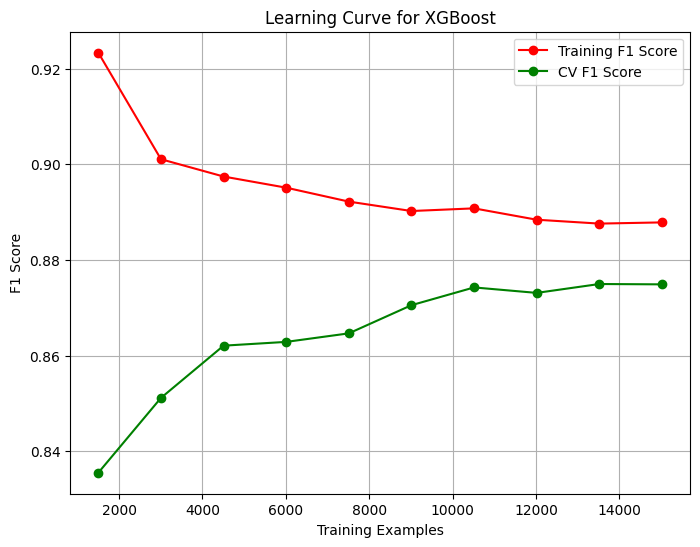

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

# -----------------------------
# 1. 训练 XGBoost 模型
# -----------------------------
# 定义 XGBoost 模型，注意关闭 use_label_encoder 并设置 eval_metric
xgb_model = XGBClassifier(random_state=222, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# -----------------------------
# 2. 模型评估
# -----------------------------
# 在测试集上进行预测
y_pred = xgb_model.predict(X_test)

# 计算评估指标
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))

if hasattr(xgb_model, "predict_proba"):
    y_proba = xgb_model.predict_proba(X_test)[:, 1]
    print("ROC AUC: {:.4f}".format(roc_auc_score(y_test, y_proba)))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# -----------------------------
# 3. 绘制学习曲线
# -----------------------------
def plot_learning_curve2(model, X, y, cv=5, scoring='f1', n_jobs=-1):
    """
    绘制模型的学习曲线
    参数：
      model: 待训练模型
      X, y: 训练数据
      cv: 交叉验证折数（默认 5）
      scoring: 评估指标（默认 'f1'）
      n_jobs: 并行计算核数（默认 -1，使用所有核）
    """
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y,
        cv=cv,
        scoring=scoring,
        train_sizes=np.linspace(0.1, 1.0, 10),
        n_jobs=n_jobs
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training F1 Score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="CV F1 Score")
    plt.title("Learning Curve for XGBoost")
    plt.xlabel("Training Examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.show()

# 绘制 XGBoost 模型的学习曲线
plot_learning_curve2(xgb_model, X_train, y_train, cv=5, scoring='f1')

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


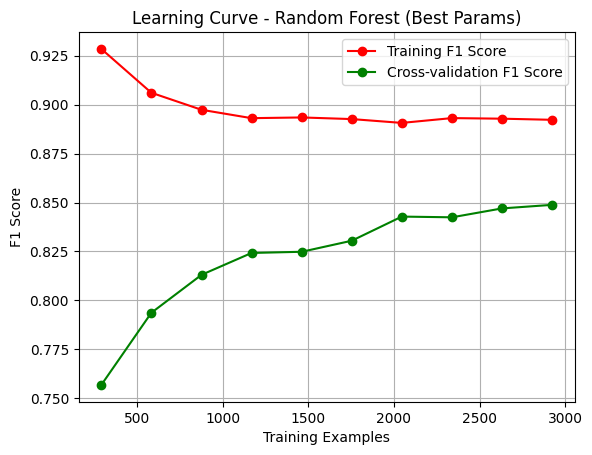

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 定义随机森林模型的参数搜索空间
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# 创建随机森林分类器（指定随机种子保证结果可复现）
rf = RandomForestClassifier(random_state=222)

# 初始化 GridSearchCV，采用5折交叉验证，优化目标为 F1 分数
grid_search_rf = GridSearchCV(estimator=rf,
                              param_grid=param_grid,
                              cv=5,
                              scoring='f1',
                              n_jobs=-1,
                              verbose=2)

# 在 SMOTE 平衡后的训练数据上进行网格搜索
grid_search_rf.fit(X_train_sm, y_train_sm)

# 获取最佳的随机森林模型
best_rf = grid_search_rf.best_estimator_

# 使用最佳模型绘制学习曲线
plot_learning_curve(best_rf, X_sample, y_sample, "Random Forest (Best Params)")

In [ ]:
print("Best Parameters: ", grid_search_rf.best_params_)
print("Best F1 Score: ", grid_search_rf.best_score_)

Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score:  0.87601191132574


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# 定义最佳参数
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 222
}

X_sample, _, y_sample, _ = train_test_split(
    X_train_sm, y_train_sm, train_size=0.2, random_state=222, stratify=y_train_sm
)

# 构建随机森林模型并拟合数据
rf_best = RandomForestClassifier(**best_params)
rf_best.fit(X_sample, y_sample)

# 使用 SelectFromModel 进行特征选择，阈值设为中位数
selector = SelectFromModel(rf_best, threshold='median', prefit=True)
X_selected = selector.transform(X_sample)

# 获取被选择特征的名称
selected_features = X_sample.columns[selector.get_support()]

print("Selected Features:")
print(selected_features)
print("Original feature shape:", X_sample.shape)
print("Selected feature shape:", X_selected.shape)

Selected Features:
Index(['ever_married', 'gender_Male', 'work_type_Private',
       'work_type_children', 'Residence_type_Urban',
       'smoking_status_never smoked', 'age_group_Middle-aged',
       'age_group_Elderly', 'age_group_Very Elderly',
       'glucose_category_Normal'],
      dtype='object')
Original feature shape: (3656, 20)
Selected feature shape: (3656, 10)


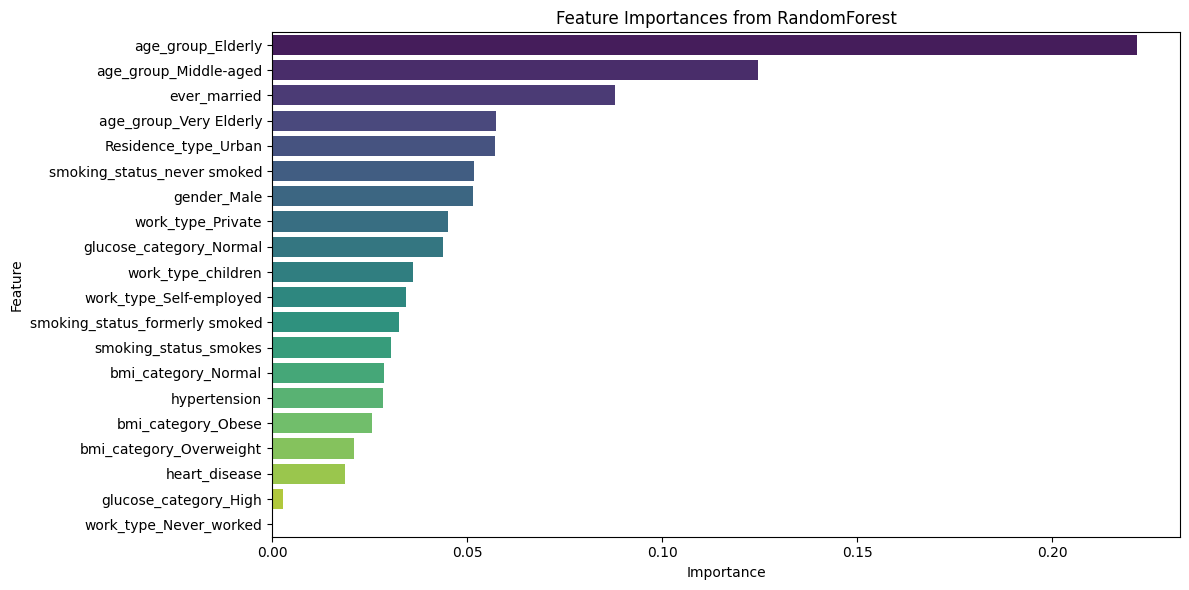

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 rf_best 是之前用最佳参数拟合好的随机森林模型，X_sample 是特征数据
# 提取特征重要性
importances = rf_best.feature_importances_
features = X_sample.columns

# 构建 DataFrame 用于可视化
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
})

# 按重要性排序
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 绘制条形图
plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance_df, palette="viridis")
plt.title('Feature Importances from RandomForest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Feature Importances (sorted):
                           feature  importance
13               age_group_Elderly    0.221609
12           age_group_Middle-aged    0.124638
2                     ever_married    0.087881
14          age_group_Very Elderly    0.057481
8             Residence_type_Urban    0.057171
10     smoking_status_never smoked    0.051873
3                      gender_Male    0.051399
5                work_type_Private    0.045150
18         glucose_category_Normal    0.043692
7               work_type_children    0.036092
6          work_type_Self-employed    0.034275
9   smoking_status_formerly smoked    0.032568
11           smoking_status_smokes    0.030613
15             bmi_category_Normal    0.028728
0                     hypertension    0.028387
17              bmi_category_Obese    0.025669
16         bmi_category_Overweight    0.021015
1                    heart_disease    0.018689
19           glucose_category_High    0.002873
4           work_type_Never_wo

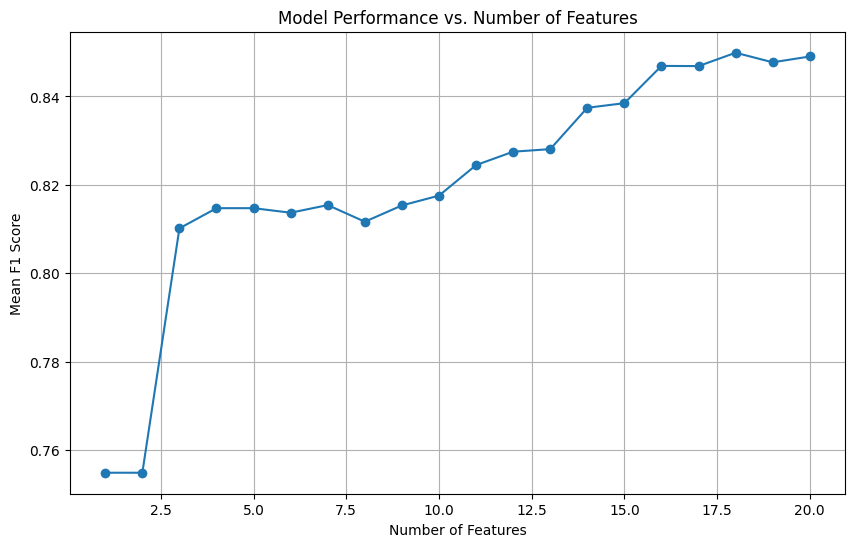

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# 获取各特征的重要性，并按照降序排序
importances = rf_best.feature_importances_
features = X_sample.columns
feature_importance_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 打印各特征的重要性排序
print("Feature Importances (sorted):")
print(feature_importance_df)

# 将排序后的特征名称存入列表
sorted_features = feature_importance_df['feature'].tolist()

# 定义存储不同特征数量下模型表现的列表
feature_counts = []
f1_scores = []

# 测试使用前 k 个特征时模型的表现，k 从 1 到全部特征
for k in range(1, len(sorted_features) + 1):
    selected_features = sorted_features[:k]
    X_subset = X_sample[selected_features]

    # 使用最佳参数构造模型
    model = RandomForestClassifier(**best_params)

    # 5折交叉验证，计算 F1 得分
    scores = cross_val_score(model, X_subset, y_sample, cv=5, scoring='f1', n_jobs=-1)
    mean_score = np.mean(scores)

    feature_counts.append(k)
    f1_scores.append(mean_score)

    print(f"Using top {k} features: Mean F1 Score = {mean_score:.4f}")

# 绘制不同特征数量下模型的 F1 表现
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, f1_scores, marker='o', linestyle='-')
plt.xlabel('Number of Features')
plt.ylabel('Mean F1 Score')
plt.title('Model Performance vs. Number of Features')
plt.grid(True)
plt.show()

Top 18 features selected:
['age_group_Very Elderly', 'age_group_Middle-aged', 'ever_married', 'age_group_Elderly', 'Residence_type_Urban', 'gender_Male', 'work_type_Private', 'work_type_children', 'glucose_category_Normal', 'smoking_status_never smoked', 'bmi_category_Normal', 'work_type_Self-employed', 'smoking_status_formerly smoked', 'hypertension', 'smoking_status_smokes', 'bmi_category_Obese', 'glucose_category_High', 'bmi_category_Overweight']

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2348
           1       0.82      0.94      0.88      2347

    accuracy                           0.87      4695
   macro avg       0.88      0.87      0.87      4695
weighted avg       0.88      0.87      0.87      4695

Accuracy: 0.8718
F1 Score: 0.8804
ROC AUC: 0.9369
Confusion Matrix:
[[1877  471]
 [ 131 2216]]


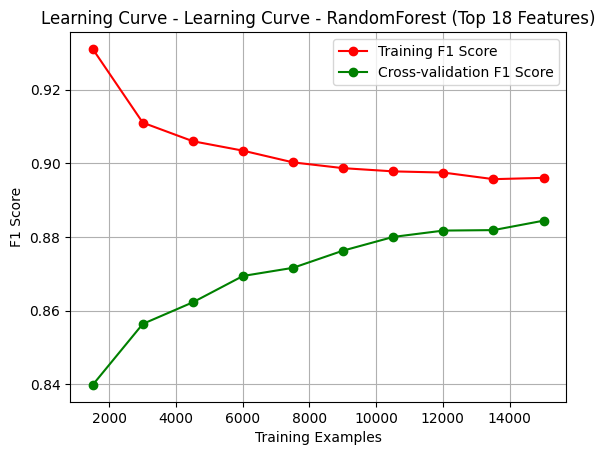

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

# 假设 X_train_sm, y_train_sm, X_test, y_test 已经存在
# 定义最佳参数（包含随机种子）
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 222
}

# ================================
# 第一步：利用最佳参数训练模型，并提取特征重要性
# ================================
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# 获取特征重要性
importances = rf_model.feature_importances_
features = X_train.columns

# 构建 DataFrame，按重要性降序排序
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 选择排名前18的特征
top_features = importance_df['feature'].head(18).tolist()
print("Top 18 features selected:")
print(top_features)

# ================================
# 第二步：构建基于选定特征的训练集和测试集
# ================================
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# ================================
# 第三步：在训练集上训练模型，在测试集上进行预测并输出评分
# ================================
rf_top = RandomForestClassifier(**best_params)
rf_top.fit(X_train_top, y_train)

# 预测测试集
y_pred = rf_top.predict(X_test_top)

# 输出各项评分
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
if hasattr(rf_top, "predict_proba"):
    y_proba = rf_top.predict_proba(X_test_top)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 使用最终模型在选定特征的训练集上绘制学习曲线
plot_learning_curve(rf_top, X_train_top, y_train, "Learning Curve - RandomForest (Top 18 Features)")

Top 18 features selected:
['age_group_Very Elderly', 'age_group_Middle-aged', 'ever_married', 'age_group_Elderly', 'Residence_type_Urban', 'gender_Male', 'work_type_Private', 'work_type_children', 'glucose_category_Normal', 'smoking_status_never smoked', 'bmi_category_Normal', 'work_type_Self-employed', 'smoking_status_formerly smoked', 'hypertension', 'smoking_status_smokes', 'bmi_category_Obese', 'glucose_category_High', 'bmi_category_Overweight']

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2348
           1       0.82      0.94      0.88      2347

    accuracy                           0.87      4695
   macro avg       0.88      0.87      0.87      4695
weighted avg       0.88      0.87      0.87      4695

Accuracy: 0.8718
F1 Score: 0.8804
ROC AUC: 0.9369
Confusion Matrix:
[[1877  471]
 [ 131 2216]]


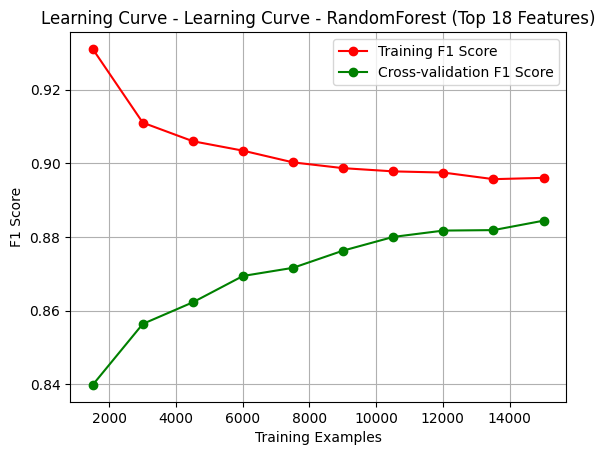

In [ ]:
#X_train, X_test, y_train, y_test
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

# 定义最佳参数（包含随机种子）
best_params = {
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 100,
    'random_state': 222
}

# ================================
# 第一步：利用最佳参数训练模型，并提取特征重要性
# ================================
rf_model = RandomForestClassifier(**best_params)
rf_model.fit(X_train, y_train)

# 获取特征重要性
importances = rf_model.feature_importances_
features = X_train.columns

# 构建 DataFrame，按重要性降序排序
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# 选择排名前18的特征
top_features = importance_df['feature'].head(18).tolist()
print("Top 18 features selected:")
print(top_features)

# ================================
# 第二步：构建基于选定特征的训练集和测试集
# ================================
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# ================================
# 第三步：在训练集上训练模型，在测试集上进行预测并输出评分
# ================================
rf_top = RandomForestClassifier(**best_params)
rf_top.fit(X_train_top, y_train)

# 预测测试集
y_pred = rf_top.predict(X_test_top)

# 输出各项评分
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
if hasattr(rf_top, "predict_proba"):
    y_proba = rf_top.predict_proba(X_test_top)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 使用最终模型在选定特征的训练集上绘制学习曲线
plot_learning_curve(rf_top, X_train_top, y_train, "Learning Curve - RandomForest (Top 18 Features)")


Voting Classifier Performance:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      2348
           1       0.83      0.94      0.88      2347

    accuracy                           0.87      4695
   macro avg       0.88      0.87      0.87      4695
weighted avg       0.88      0.87      0.87      4695

Accuracy: 0.8707
F1 Score: 0.8790
ROC AUC: 0.9304
Confusion Matrix:
[[1883  465]
 [ 142 2205]]


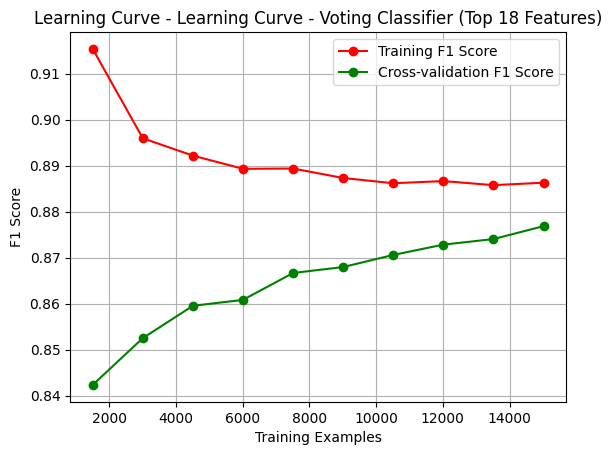

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import learning_curve

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier  # 用作 pycart 的替代
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier  # 导入神经网络模型

# 构建其它基模型（使用默认参数）
lr = LogisticRegression(max_iter=1000, random_state=222)
gb = GradientBoostingClassifier(random_state=222)
xgb = XGBClassifier(random_state=222)
lgb = LGBMClassifier(random_state=222)
pycart = DecisionTreeClassifier(random_state=222)
nn = MLPClassifier(random_state=222)  # 神经网络模型

# 构建 VotingClassifier，使用软投票，将神经网络模型加入其中
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf_top),
        ('lr', lr),
        ('gb', gb),
        ('xgb', xgb),
        ('lgb', lgb),
        ('pycart', pycart),
        ('nn', nn)
    ],
    voting='soft',
    n_jobs=-1
)

# 训练 VotingClassifier（在 top 18 特征的训练集上）
voting_clf.fit(X_train_top, y_train)

# 在测试集上进行预测
y_pred = voting_clf.predict(X_test_top)

# 输出模型表现
print("Voting Classifier Performance:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
if hasattr(voting_clf, "predict_proba"):
    y_proba = voting_clf.predict_proba(X_test_top)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ------------------------------
# 绘制 VotingClassifier 的学习曲线（在训练集上进行交叉验证）
# ------------------------------
plot_learning_curve(voting_clf, X_train_top, y_train, "Learning Curve - Voting Classifier (Top 18 Features)")

In [ ]:
# 定义第一层基模型，其中将原来的 'rf' 替换为决策树
estimators = [
    ('dt', DecisionTreeClassifier(random_state=222)),
    ('lr', LogisticRegression(max_iter=1000, random_state=222)),
    ('gb', GradientBoostingClassifier(random_state=222)),
    ('xgb', XGBClassifier(random_state=222, use_label_encoder=False, eval_metric='logloss')),
    ('lgb', LGBMClassifier(random_state=222))
]

# 定义第二层的元学习器，直接使用已经训练好的 rf_top
final_estimator = rf_top

# 构造 StackingClassifier，cv=5 表示使用 5 折交叉验证来生成基模型的预测
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1,
    passthrough=False  # 如果设置为 True，则将原始特征也传递给最终模型
)

# --------------------------
# 模型训练与评估
# --------------------------
# 在训练集上训练 stacking ensemble 模型
stacking_clf.fit(X_train, y_train)

# 在测试集上预测
y_pred = stacking_clf.predict(X_test)

# 如果模型支持 predict_proba，则计算 ROC AUC
if hasattr(stacking_clf, "predict_proba"):
    y_proba = stacking_clf.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_proba)
else:
    roc_auc = None

# 输出评估结果
print("Stacking Ensemble Evaluation:")
print(classification_report(y_test, y_pred))
print("Accuracy: {:.4f}".format(accuracy_score(y_test, y_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_pred)))
if roc_auc is not None:
    print("ROC AUC: {:.4f}".format(roc_auc))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# 绘制 stacking ensemble 模型在训练集上的学习曲线
#plot_learning_curve(stacking_clf, X_train, y_train, "Stacking Ensemble Learning Curve")

Stacking Ensemble Evaluation:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87      2348
           1       0.83      0.95      0.89      2347

    accuracy                           0.88      4695
   macro avg       0.89      0.88      0.88      4695
weighted avg       0.89      0.88      0.88      4695

Accuracy: 0.8786
F1 Score: 0.8862
ROC AUC: 0.9367
Confusion Matrix:
[[1906  442]
 [ 128 2219]]


In [ ]:
# FINAL STEP - MAKE PREDICTIONS

# Drop unnecessary columns in test data to match training features


# 从 test 数据中筛选出训练时使用的特征
test_selected = test[top_features]
#test_selected = test.drop('id', axis=1)
# 使用训练好的模型进行预测
predictions = voting_clf.predict(test_selected)

# Create a DataFrame with id and price columns
submission_df = pd.DataFrame({
    'id': range(1, len(test) + 1),
    'target': predictions
})

# Save to submit.csv
submission_df.to_csv('submit.csv', index=False)
print("submit.csv file created successfully!")


# Alternatives to saving the CSV file
# output_txt_path = "/mnt/data/stroke_predictions.txt"
# df_test[['predicted_price']].to_csv(output_txt_path, index=False, sep="\t")
# output_json_path = "/mnt/data/stroke_predictions.json"
# df_test[['predicted_price']].to_json(output_json_path, orient="records", lines=True)

submit.csv file created successfully!
